In [5]:
!pip install sparse_lmm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np

clinical_data = pd.read_csv('TCGA dataset/TCGA_Lung_Cancer_(LUNG)/TCGA.LUNG.sampleMap_LUNG_clinicalMatrix', sep='\t', index_col=0)
gene_data = pd.read_csv('TCGA dataset/TCGA_Lung_Cancer_(LUNG)/TCGA.LUNG.sampleMap_HiSeqV2_PANCAN.gz', sep='\t', index_col=0)

In [7]:
clinical_data.head()

,ABSOLUTE_Ploidy,ABSOLUTE_Purity,AKT1,ALK_translocation,BRAF,CBL,CTNNB1,Canonical_mut_in_KRAS_EGFR_ALK,Cnncl_mt_n_KRAS_EGFR_ALK_RET_ROS1_BRAF_ERBB2_HRAS_NRAS_AKT1_MAP2,EGFR,...,_GENOMIC_ID_TCGA_LUNG_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_LUNG_hMethyl27,_GENOMIC_ID_TCGA_LUNG_mutation,_GENOMIC_ID_TCGA_LUNG_exp_HiSeqV2_PANCAN,_GENOMIC_ID_TCGA_LUNG_hMethyl450,_GENOMIC_ID_TCGA_LUNG_gistic2thd,_GENOMIC_ID_TCGA_LUNG_G4502A_07_3,_GENOMIC_ID_TCGA_LUNG_exp_HiSeqV2,_GENOMIC_ID_TCGA_LUNG_gistic2,_GENOMIC_ID_TCGA_LUNG_RPPA_RBN
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,e6a101b9-61f9-4ed1-a59f-d9db3fdb4555,TCGA-05-4244-01A-01D-1104-05,TCGA-05-4244-01A-01D-1105-08,e6a101b9-61f9-4ed1-a59f-d9db3fdb4555,NaN,TCGA-05-4244-01A-01D-1877-01,TCGA-05-4244-01A-01R-1107-07,e6a101b9-61f9-4ed1-a59f-d9db3fdb4555,TCGA-05-4244-01A-01D-1877-01,TCGA-05-4244-01A-21-2190-20
TCGA-05-4249-01,3.77,0.46,none,NaN,p.A762E,none,none,Y,Y,none,...,d1a8d88d-1708-4959-9695-6f2e67853bd5,TCGA-05-4249-01A-01D-1104-05,TCGA-05-4249-01A-01D-1105-08,d1a8d88d-1708-4959-9695-6f2e67853bd5,NaN,TCGA-05-4249-01A-01D-1877-01,TCGA-05-4249-01A-01R-1107-07,d1a8d88d-1708-4959-9695-6f2e67853bd5,TCGA-05-4249-01A-01D-1877-01,TCGA-05-4249-01A-21-2190-20
TCGA-05-4250-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,bba9333a-09f7-4585-b22e-e4ae4049f7da,TCGA-05-4250-01A-01D-1104-05,TCGA-05-4250-01A-01D-1105-08,bba9333a-09f7-4585-b22e-e4ae4049f7da,NaN,TCGA-05-4250-01A-01D-1877-01,TCGA-05-4250-01A-01R-1107-07,bba9333a-09f7-4585-b22e-e4ae4049f7da,TCGA-05-4250-01A-01D-1877-01,TCGA-05-4250-01A-21-2190-20
TCGA-05-4382-01,NaN,NaN,none,NaN,p.L613F,none,none,N,N,"p.R222L, p.E545Q",...,e4177b01-6898-4bb7-b38d-0c09f85c5668,TCGA-05-4382-01A-01D-1205-05,TCGA-05-4382-01A-01D-1265-08,e4177b01-6898-4bb7-b38d-0c09f85c5668,NaN,TCGA-05-4382-01A-01D-1204-01,NaN,e4177b01-6898-4bb7-b38d-0c09f85c5668,TCGA-05-4382-01A-01D-1204-01,NaN
TCGA-05-4384-01,2.04,0.48,none,NaN,none,none,p.F777S,N,N,none,...,7d6cf896-b04a-431a-a192-aaf540eeaf77,NaN,TCGA-05-4384-01A-01D-1753-08,7d6cf896-b04a-431a-a192-aaf540eeaf77,TCGA-05-4384-01A-01D-1756-05,TCGA-05-4384-01A-01D-1752-01,NaN,7d6cf896-b04a-431a-a192-aaf540eeaf77,TCGA-05-4384-01A-01D-1752-01,TCGA-05-4384-01A-21-2190-20


In [8]:
gene_fullname = 'KRAS gene'
gene = 'kras'
condition = 'obesity'
condition_col = 'initial_weight'
trait = 'Lung Cancer'

# Get the feature dimension of clinical data, and the number of genes
col_offset = len(clinical_data.columns)
num_genes = len(gene_data)
print(f'The clinical dataset has {col_offset} features, and the gene dataset includes {num_genes} genes')
gene_data.T

The clinical dataset has 133 features, and the gene dataset includes 20530 genes


sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-NJ-A4YP-01,-0.213692,-2.780026,-0.531035,0.040728,-0.699378,-0.42951,-0.384894,0.702354,-0.423399,2.888328,...,0.068522,-1.587117,0.931767,-0.46399,-0.002677,0.745714,1.461773,-0.426195,-0.645033,0.400188
TCGA-18-3417-01,-2.032992,-0.775126,0.573765,0.365228,0.364522,0.31389,-0.245994,0.016254,-0.423399,-1.116572,...,-0.748878,-1.587117,0.304967,2.60701,1.302623,1.025014,-0.381027,0.839305,-1.085033,0.533188
TCGA-22-4613-01,-1.109192,-1.023426,-0.531035,-0.326772,0.308122,1.19219,-0.814294,-0.618246,1.046401,-2.143072,...,-0.748878,-1.587117,0.779667,1.15821,0.124023,-0.396686,-0.781327,-0.732495,1.733867,0.624488
TCGA-90-7769-01,-1.270392,-3.254826,-0.090835,0.160728,0.368322,-0.52621,0.506406,-1.370946,0.016801,-3.830172,...,0.028022,-1.587117,-2.528233,2.07981,-0.431477,0.094714,-2.267827,-1.137095,-1.210233,0.153688
TCGA-62-8397-01,0.677108,1.092974,-0.531035,0.583528,0.314922,-0.66211,0.026106,-1.488746,-0.423399,1.381928,...,-0.748878,-1.587117,0.913367,0.01721,-0.338677,-0.005186,-0.735227,0.204105,1.336567,-0.598212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-O2-A5IB-01,0.568508,0.025974,0.084865,-0.009372,-0.136278,-1.41811,0.173506,-2.194046,0.622701,2.913828,...,-0.408378,-1.246617,-1.940533,-1.28139,1.281723,-2.425586,-0.734427,-1.926795,-2.121633,-0.637412
TCGA-67-3771-01,-0.521492,5.729974,0.192765,-0.279272,0.486522,1.57219,-0.779794,-0.324146,-0.423399,1.929528,...,3.249622,-0.863317,0.416067,-1.28139,-0.511277,-0.866086,0.537473,-1.508595,0.356667,0.786188
TCGA-77-7335-01,-0.849892,-2.414126,0.192865,0.197228,0.443922,0.54789,0.084406,1.015054,-0.423399,0.130728,...,-0.748878,-1.587117,2.160367,1.19391,0.197023,1.550114,0.294773,0.369005,1.909267,0.117688
TCGA-55-8302-01,0.305608,-0.018326,-0.531035,0.003728,-0.451578,-0.38671,-0.084494,-0.217746,-0.423399,-0.706872,...,-0.748878,-1.587117,1.078867,-1.28139,0.280623,0.634014,-0.909527,-0.114895,0.848867,0.195588


In [9]:
# Merge clinical_data and gene_data on their indices - sample_ID, corresponding to each person
merged_data = clinical_data.join(gene_data.T, rsuffix='_gd')

merged_data.head()

,ABSOLUTE_Ploidy,ABSOLUTE_Purity,AKT1,ALK_translocation,BRAF,CBL,CTNNB1,Canonical_mut_in_KRAS_EGFR_ALK,Cnncl_mt_n_KRAS_EGFR_ALK_RET_ROS1_BRAF_ERBB2_HRAS_NRAS_AKT1_MAP2,EGFR,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015022,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812
TCGA-05-4249-01,3.77,0.46,none,NaN,p.A762E,none,none,Y,Y,none,...,-0.031778,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212
TCGA-05-4250-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.748878,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812
TCGA-05-4382-01,NaN,NaN,none,NaN,p.L613F,none,none,N,N,"p.R222L, p.E545Q",...,1.013722,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588
TCGA-05-4384-01,2.04,0.48,none,NaN,none,none,p.F777S,N,N,none,...,-0.060978,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712


In [10]:
# Only select relevant columns
input_cols = [condition_col] + merged_data.columns[col_offset: col_offset + num_genes].tolist()
merged_data = merged_data[input_cols]

# Remove sample rows with missing columns.
threshold_rows = 0.8 * len(merged_data)
rows_after_any = len(merged_data.dropna(how='any'))

# Prefer "how='any'", if it does not discard too much data.
if rows_after_any >= threshold_rows:
    merged_data = merged_data.dropna(how='any')
else:
    merged_data = merged_data.dropna(how='all')
    merged_data = merged_data.fillna(0)

merged_data.head()

,initial_weight,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,0.0,-0.056592,2.128674,-0.531035,-0.185972,-0.190878,-0.11891,-0.659794,-1.204246,0.008601,...,0.015022,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812
TCGA-05-4249-01,0.0,-0.569692,-0.318126,-0.531035,0.237428,0.011822,-0.00611,1.018406,0.313854,-0.423399,...,-0.031778,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212
TCGA-05-4250-01,0.0,-0.899992,-0.918126,-0.531035,-0.621472,-0.454178,0.58719,-0.198894,-1.153846,-0.423399,...,-0.748878,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812
TCGA-05-4382-01,0.0,0.667508,3.895974,-0.221535,-0.367272,0.131822,0.97629,-0.494994,1.059554,0.357201,...,1.013722,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588
TCGA-05-4384-01,0.0,-0.316892,2.380374,0.156865,0.232828,0.054822,0.27059,0.128606,0.440354,-0.423399,...,-0.060978,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712


In [11]:

def mark_tumor(row_index):
    last_two_digits = int(row_index[-2:])

    if 1 <= last_two_digits <= 9:
        return 1
    elif 10 <= last_two_digits <= 19:
        return 0
    else:
        return -1

# Use the apply function to add the trait column to merged_data
merged_data[trait] = merged_data.index.to_series().apply(mark_tumor)

merged_data.head()

,initial_weight,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Lung Cancer
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,0.0,-0.056592,2.128674,-0.531035,-0.185972,-0.190878,-0.11891,-0.659794,-1.204246,0.008601,...,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812,1
TCGA-05-4249-01,0.0,-0.569692,-0.318126,-0.531035,0.237428,0.011822,-0.00611,1.018406,0.313854,-0.423399,...,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212,1
TCGA-05-4250-01,0.0,-0.899992,-0.918126,-0.531035,-0.621472,-0.454178,0.58719,-0.198894,-1.153846,-0.423399,...,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812,1
TCGA-05-4382-01,0.0,0.667508,3.895974,-0.221535,-0.367272,0.131822,0.97629,-0.494994,1.059554,0.357201,...,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588,1
TCGA-05-4384-01,0.0,-0.316892,2.380374,0.156865,0.232828,0.054822,0.27059,0.128606,0.440354,-0.423399,...,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712,1


In [13]:
input_cols = merged_data.columns.tolist()
gene_list = [col for col in input_cols if gene in col.lower()]

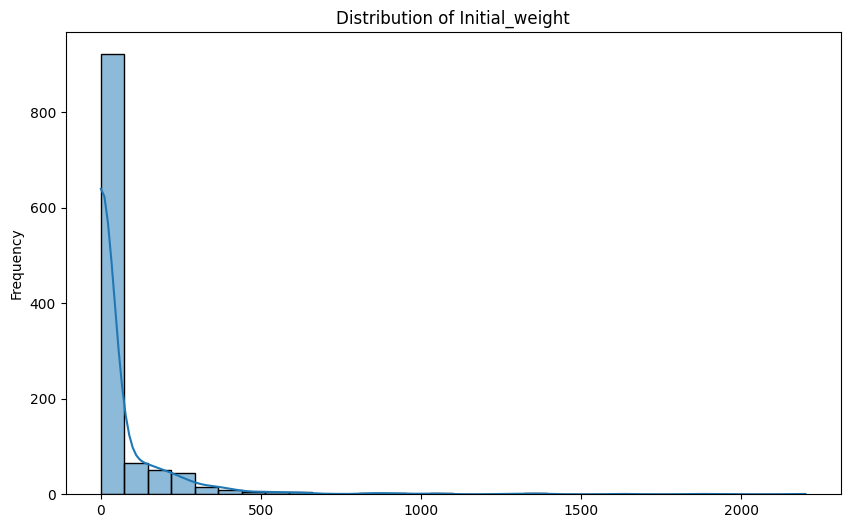

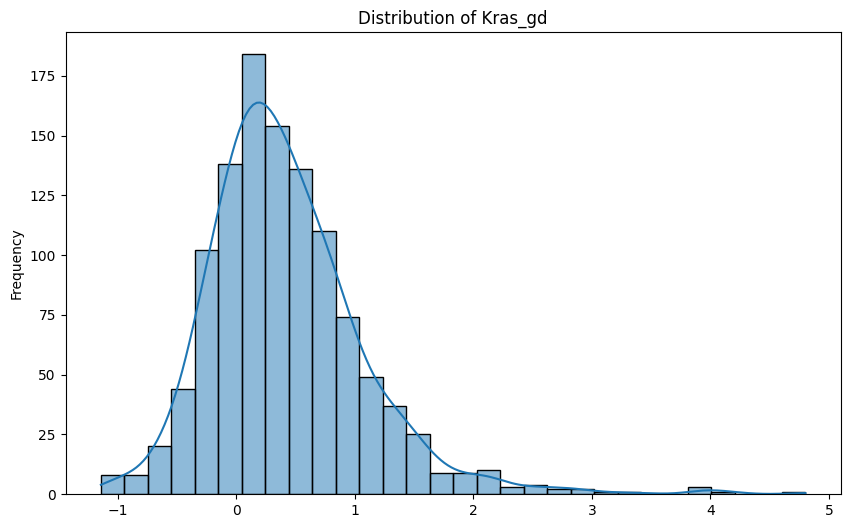

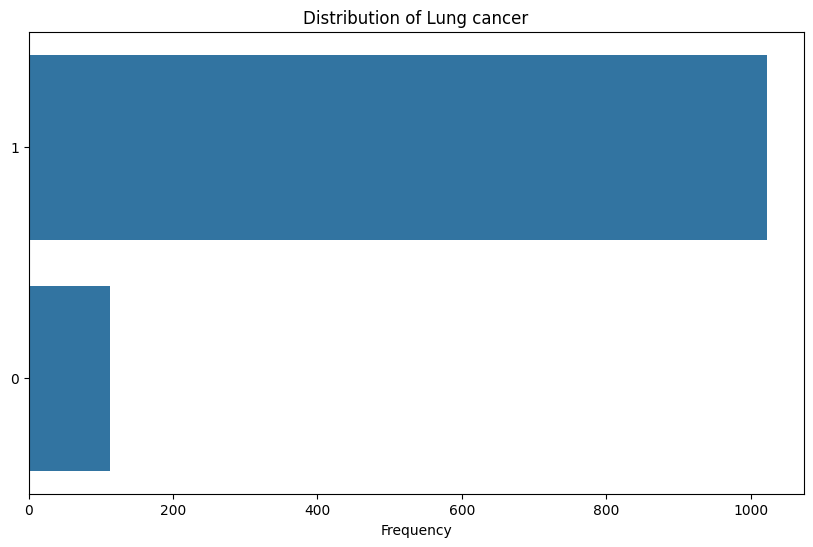

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

def analyze_distributions(df, numerical_columns, categorical_columns):
    for col in numerical_columns:
        plot_numeric_distribution(df, col)

    for col in categorical_columns:
        plot_categorical_distribution(df, col)

# Sample usage:
analyze_distributions(merged_data, numerical_columns=[condition_col, *gene_list], categorical_columns=[trait])

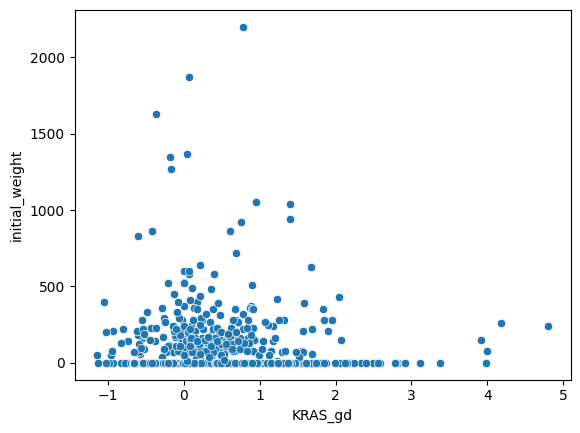

In [15]:
sns.scatterplot(data=merged_data, x='KRAS_gd', y=condition_col)
plt.show()

In [16]:
# Convert "day_to_birth" to age in years
merged_data[condition_col] = (- merged_data[condition_col] / 365.25).astype(int)
merged_data = merged_data.rename(columns={condition_col: condition})
input_cols = merged_data.columns.tolist()

merged_data.head()

,obesity,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Lung Cancer
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,0,-0.056592,2.128674,-0.531035,-0.185972,-0.190878,-0.11891,-0.659794,-1.204246,0.008601,...,-1.155117,0.528367,2.75061,0.428423,-0.639586,-0.195527,-0.324695,0.193167,-0.572812,1
TCGA-05-4249-01,0,-0.569692,-0.318126,-0.531035,0.237428,0.011822,-0.00611,1.018406,0.313854,-0.423399,...,-0.393117,1.632467,2.33551,-0.145577,-0.997486,-0.276027,-1.219395,1.850967,-0.471212,1
TCGA-05-4250-01,0,-0.899992,-0.918126,-0.531035,-0.621472,-0.454178,0.58719,-0.198894,-1.153846,-0.423399,...,-1.173917,1.966367,-1.28139,-0.374877,0.959514,0.714373,0.112305,-0.532833,-0.003812,1
TCGA-05-4382-01,0,0.667508,3.895974,-0.221535,-0.367272,0.131822,0.97629,-0.494994,1.059554,0.357201,...,-1.587117,0.359267,2.59051,0.806623,0.812114,0.367373,-0.494595,-1.062233,0.108588,1
TCGA-05-4384-01,0,-0.316892,2.380374,0.156865,0.232828,0.054822,0.27059,0.128606,0.440354,-0.423399,...,-0.435417,1.111467,-1.28139,-0.128477,0.110214,1.469373,0.194605,1.404667,-0.290712,1


In [17]:
import pandas as pd
from sparse_lmm import VariableSelection

# Select relevant columns and convert to numpy array
data_array = merged_data.values

# Normalize data
X = data_array
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
zero_std_columns = np.where(std == 0)[0]
X = (X - mean) / std
X[:, zero_std_columns] = 0

y = merged_data[trait].values

# Implementing k-fold cross-validation
def cross_validation(X, y, k=5):
    # Shuffle data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    fold_size = len(X) // k
    accuracies = []

    for i in range(k):
        # Split data into train and test based on the current fold
        test_indices = indices[i*fold_size : (i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X_shuffled[train_indices], X_shuffled[test_indices]
        y_train, y_test = y_shuffled[train_indices], y_shuffled[test_indices]

        # Use the precision_lasso package for regression
        var_select = VariableSelection()
        var_select.fit(X_train, y_train)
        predictions = var_select.predict(X_test)

        # Turn the predictions into binary values using a threshold of 0.5
        binary_predictions = (predictions > 0.5).astype(int)

        # Calculate accuracy for this fold
        accuracy = np.mean(binary_predictions == y_test)
        accuracies.append(accuracy)

    return np.mean(accuracies)

print(cross_validation(data_array, y))

C:\Users\Bobibob\AppData\Local\Temp\ipykernel_26036\2284219672.py:12: RuntimeWarning: invalid value encountered in divide
  X = (X - mean) / std
C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\helpingMethods.py:49: RuntimeWarning: invalid value encountered in divide
  ts = beta / np.sqrt(var * sigma)
C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\VariableSelection.py:183: RuntimeWarning: divide by zero encountered in log
  return -np.log(p), np.array(betas)


0.8828931281414348


In [18]:
# Conduct regression on the whole dataset
# Instantiate the VariableSelection class
var_select = VariableSelection()

# Fit the model
var_select.fit(X, y)

# Retrieve the coefficients
coefficients = var_select.getBeta().reshape(-1).tolist()
nlog_p_values = var_select.getNegLogP().reshape(-1).tolist()

In [19]:
# Print regression result

gene_result = []
condition_result = []

# Extract information related to the regressors
for var, coef, nlogp in zip(input_cols, coefficients, nlog_p_values):
    if gene in var.lower():
        gene_result.append((var, coef, np.exp(-nlogp)))
    if condition == var.lower():
        condition_result.append((var, coef, np.exp(-nlogp)))

regression_report = "Regression Results:\n\n"
regression_report += f"For {gene}:\n"
for variable_name, coefficient, p_value in gene_result:
    regression_report += f"{variable_name}: Coefficient = {coefficient}, p-value = {p_value}\n"

regression_report += f"\nFor {condition}:\n"
for variable_name, coefficient, p_value in condition_result:
    regression_report += f"{variable_name}: Coefficient = {coefficient}, p-value = {p_value}\n"

print(regression_report)

Regression Results:

For kras:
KRAS_gd: Coefficient = 0.00047420748948562015, p-value = 0.9706108768258183

For obesity:
obesity: Coefficient = 0.06847309525622475, p-value = 3.1493726771385276e-21



In [20]:
# Generate hypothesis text

hypotheses_text = f'Hypothesis\n\n'
hypotheses_text += f'For the question "What is the relationship between {gene_fullname} and {trait} when considering the influence of {condition}?", the following hypotheses can be proposed:\n\n'
hypotheses_text += f'Null Hypothesis (H0): There is no significant association between the expression of the {gene_fullname} and {trait} when considering the influence of {condition}.\n\n'
hypotheses_text += f'Alternative Hypothesis (H1): There is an association between the expression of the {gene_fullname} and {trait} when considering the influence of {condition}.\n\n'

print(hypotheses_text)

Hypothesis

For the question "What is the relationship between KRAS gene and Lung Cancer when considering the influence of obesity?", the following hypotheses can be proposed:

Null Hypothesis (H0): There is no significant association between the expression of the KRAS gene and Lung Cancer when considering the influence of obesity.

Alternative Hypothesis (H1): There is an association between the expression of the KRAS gene and Lung Cancer when considering the influence of obesity.




In [21]:
# Interpretation of Regression Coefficients

threshold = 0.05
def interpret_coefficient(variable_name, coefficient, p_value, significance_level=0.05):
    interpretation = f"Variable: {variable_name}\n"

    if coefficient > 0:
        interpretation += "Coefficient is positive, "
    elif coefficient < 0:
        interpretation += "Coefficient is negative, "
    else:
        interpretation += "Coefficient is zero, "

    if p_value < threshold:
        interpretation += f"and it is statistically significant (p-value < {threshold}).\n\n"
    else:
        interpretation += f"and it is not statistically significant (p-value >= {threshold}).\n\n"

    return interpretation

# Create a report to interpret coefficients and p-values for all variables
interpretation_coefficient_report = "Interpretation of Regression Coefficients:\n\n"

for variable_name, coefficient, p_value in gene_result + condition_result:
    interpretation_coefficient_report += interpret_coefficient(variable_name, coefficient, p_value, threshold)

print(interpretation_coefficient_report)

Interpretation of Regression Coefficients:

Variable: KRAS_gd
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: obesity
Coefficient is positive, and it is statistically significant (p-value < 0.05).




In [22]:
# Hypothesis Confirmation and Conclusion

# Create a function to determine if H0 or H1 is confirmed
def confirm_hypothesis(coefficient, p_value, variable_name, significance_level=0.05):
    if p_value >= significance_level:
        return f"H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the {variable_name} gene and {trait} when considering the influence of {condition}."
    elif coefficient != 0 and p_value < significance_level:
        return f"H1 is confirmed: There is an association between the expression of the {variable_name} and {trait} when considering the influence of {condition}.\n\n"

hypothesis_confirmation_report = "Hypothesis Confirmation and Conclusion:\n\n"

for variable_name, coefficient, p_value in gene_result:
    confirmation = confirm_hypothesis(coefficient, p_value, variable_name, threshold)
    hypothesis_confirmation_report += f"Variable: {variable_name}\n"
    hypothesis_confirmation_report += f"Conclusion: {confirmation}\n\n"

print(hypothesis_confirmation_report)

Hypothesis Confirmation and Conclusion:

Variable: KRAS_gd
Conclusion: H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the KRAS_gd gene and Lung Cancer when considering the influence of obesity.


